In [1]:
from sentinelsat import SentinelAPI

user = 'joanko36' 
password = 'JoanKo36' 
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In [2]:

import geopandas as gpd
import folium 

nReserve = gpd.read_file('NReserve/NaturalReserve_Polygon.shp')

m = folium.Map([44.471092480715676, -0.5780267715454102], zoom_start=14)
folium.GeoJson(nReserve).add_to(m)
m

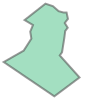

In [3]:
from shapely.geometry import MultiPolygon, Polygon

footprint = None
for i in nReserve['geometry']:
    footprint = i

footprint

In [4]:
products = api.query(footprint,
                    #  date = ('20200727', '20200729'),
                    date = ('20190601', '20190626'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10)
                    )

In [5]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,...,processingbaseline,processinglevel,producttype,platformname,size,filename,level1cpdiidentifier,identifier,uuid,geometry
16e95baf-bbcb-43fe-ab67-5fecea2ffde5,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-05T10:00:39.024Z, Instrument: MS...",false,2019-06-05 10:00:39.024,2019-06-05 10:00:39.024,2019-06-05 21:54:46.895,11731,...,02.12,Level-2A,S2MSI2A,Sentinel-2,1006.25 MB,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,S2B_OPER_MSI_L1C_TL_SGS__20190605T134619_A0117...,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,16e95baf-bbcb-43fe-ab67-5fecea2ffde5,"MULTIPOLYGON (((11.41073 41.40773, 12.72303 41..."
590a4ce9-c540-4cb9-844b-3ee1efff8ca9,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-05T10:00:39.024Z, Instrument: MS...",false,2019-06-05 10:00:39.024,2019-06-05 10:00:39.024,2019-06-05 22:16:12.999,11731,...,02.12,Level-2A,S2MSI2A,Sentinel-2,1009.58 MB,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,S2B_OPER_MSI_L1C_TL_SGS__20190605T134619_A0117...,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,590a4ce9-c540-4cb9-844b-3ee1efff8ca9,"MULTIPOLYGON (((12.70556 41.40403, 12.76314 42..."
d1a70889-1d44-414c-a357-08a7185c04b4,S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-25T10:00:39.024Z, Instrument: MS...",false,2019-06-25 10:00:39.024,2019-06-25 10:00:39.024,2019-06-25 19:50:05.133,12017,...,02.12,Level-2A,S2MSI2A,Sentinel-2,941.03 MB,S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...,S2B_OPER_MSI_L1C_TL_EPAE_20190625T123721_A0120...,S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...,d1a70889-1d44-414c-a357-08a7185c04b4,"MULTIPOLYGON (((11.41073 41.40773, 12.72303 41..."
a24e1e2c-da6a-4f2b-b19b-b97cfe4fbbe8,S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-25T10:00:39.024Z, Instrument: MS...",false,2019-06-25 10:00:39.024,2019-06-25 10:00:39.024,2019-06-25 19:48:59.153,12017,...,02.12,Level-2A,S2MSI2A,Sentinel-2,948.75 MB,S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...,S2B_OPER_MSI_L1C_TL_EPAE_20190625T123721_A0120...,S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...,a24e1e2c-da6a-4f2b-b19b-b97cfe4fbbe8,"MULTIPOLYGON (((12.70556 41.40403, 12.76314 42..."
c9e76145-3270-458c-9927-49d1354be29e,S2A_MSIL2A_20190620T100031_N0212_R122_T32TQM_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-20T10:00:31.024Z, Instrument: MS...",false,2019-06-20 10:00:31.024,2019-06-20 10:00:31.024,2019-06-20 22:10:21.392,20854,...,02.12,Level-2A,S2MSI2A,Sentinel-2,967.74 MB,S2A_MSIL2A_20190620T100031_N0212_R122_T32TQM_2...,S2A_OPER_MSI_L1C_TL_MPS__20190620T121338_A0208...,S2A_MSIL2A_20190620T100031_N0212_R122_T32TQM_2...,c9e76145-3270-458c-9927-49d1354be29e,"MULTIPOLYGON (((12.70556 41.40403, 12.76314 42..."
3155fa67-c0d6-4c0f-a556-f5e0ee532c9d,S2A_MSIL2A_20190620T100031_N0212_R122_T33TTG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-20T10:00:31.024Z, Instrument: MS...",false,2019-06-20 10:00:31.024,2019-06-20 10:00:31.024,2019-06-20 22:03:54.767,20854,...,02.12,Level-2A,S2MSI2A,Sentinel-2,961.06 MB,S2A_MSIL2A_20190620T100031_N0212_R122_T33TTG_

In [6]:
# api.download("16e95baf-bbcb-43fe-ab67-5fecea2ffde5")

In [7]:
import rasterio as rio

# Open Bands 4, 3 and 2 with Rasterio
R10 = 'S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/GRANULE/L2A_T33TTG_A011731_20190605T100530/IMG_DATA/R10m'
b4 = rio.open(R10+'/T33TTG_20190605T100039_B04_10m.jp2')
b3 = rio.open(R10+'/T33TTG_20190605T100039_B03_10m.jp2')
b2 = rio.open(R10+'/T33TTG_20190605T100039_B02_10m.jp2')


# Create an RGB image 
with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b4.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b2.read(1),3) 
    rgb.close()

#read min, max des channels
#télécharger niveau 2C (luminance > réflectance)
# masque de nuages 
# peps 

In [8]:
nReserve_proj = nReserve.to_crs({'init': 'epsg:32633'})
from rasterio.mask import mask
with rio.open("RGB.tiff") as src:
    out_image, out_transform = mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open("RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

C:\Users\Joan\anaconda3\envs\geopandas\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


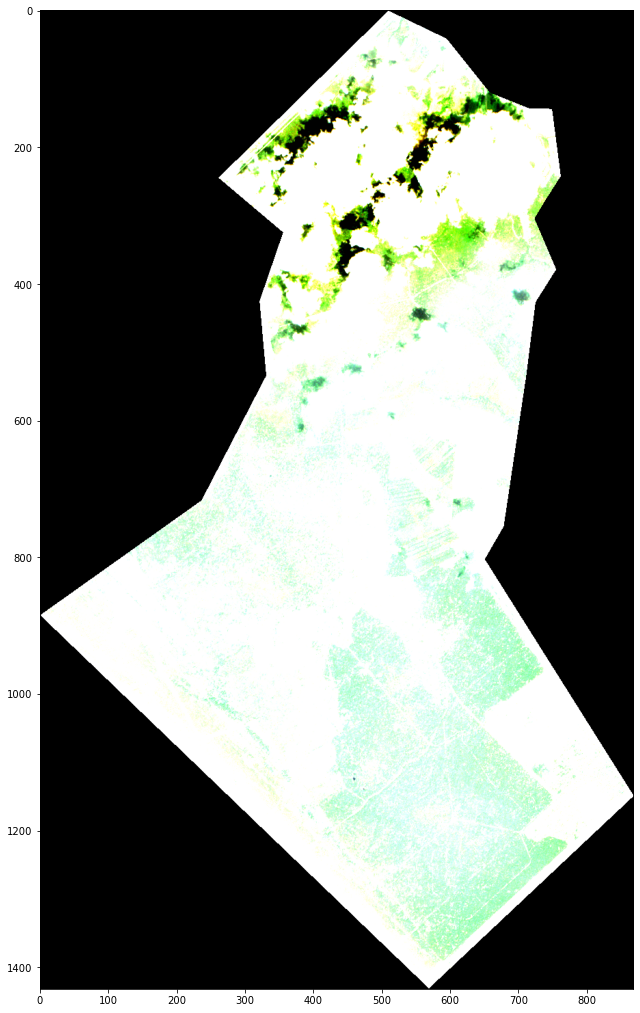

In [13]:
import matplotlib.pyplot as plt
import rasterio.plot as rplt

msk = rio.open(r"RGB_masked.tif")
fig, ax = plt.subplots(1, figsize=(18, 18))
rplt.show(msk.read([1,2,3]))
# rplt.show(msk)
plt.show()

In [10]:
# b8 = rio.open('T33TTG_20190605T100039_B08_10m.jp2')

# red = b4.read()
# nir = b8.read()

In [11]:
# ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

# meta = b4.meta

# meta.update(driver='GTiff')
# meta.update(dtype=rio.float32)

# with rio.open('NDVI.tif', 'w', **meta) as dst:
#     dst.write(ndvi.astype(rio.float32))

In [12]:
# tst = rio.open(r"NDVI.tif")
# fig, ax = plt.subplots(1, figsize=(18, 18))
# # rplt.show(msk.read([1,2,3]))
# rplt.show(tst)
# plt.show()